# QQQ Next‑Day Return Prediction with LSTM

## 1. Setup & Dependencies

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import optuna
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping




plt.style.use('seaborn-v0_8')
print("TensorFlow:", tf.__version__)
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

TensorFlow: 2.19.0


## 2. Data Ingestion

In [2]:
df = pd.read_csv('data/data_for_LSTM/QQQ.csv')

# Rename for convenience
df = df.rename(columns={
    'open_price':'open',
    'high_price':'high',
    'low_price':'low',
    'close_price':'close',
    'adj_close_price':'adj_close',
    'trading_volume':'volume'
})
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df = df[df['date'] >= '2023-01-01']
df = df[df['date'] <= '2023-12-31']
df = df.drop(columns=['outstanding_shares', 'adj_factor', 'market_cap'])
df.head()

,ticker,date,open,high,low,close,adj_close,volume
5535,QQQ,2023-01-03,268.65,270.155,262.13,264.48,264.48,42193460.0
5536,QQQ,2023-01-04,266.64,267.450,262.53,265.74,265.74,47390390.0
5537,QQQ,2023-01-05,264.04,264.210,261.26,261.58,261.58,44495950.0
5538,QQQ,2023-01-06,263.35,269.940,260.34,268.80,268.80,54551510.0
5539,QQQ,2023-01-09,270.83,275.290,269.92,270.54,270.54,45320030.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 5535 to 5784
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ticker     250 non-null    object        
 1   date       250 non-null    datetime64[ns]
 2   open       250 non-null    float64       
 3   high       250 non-null    float64       
 4   low        250 non-null    float64       
 5   close      250 non-null    float64       
 6   adj_close  250 non-null    float64       
 7   volume     250 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 17.6+ KB


In [4]:
sentiment_df = pd.read_csv('data/data_for_LSTM/nasdaq_100_daily_sentiment.csv')
sentiment_df = sentiment_df.rename(columns={
    'Date':'date',
    'SentimentScore':'sentiment_score',
    'Ticker':'ticker'
})
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
df = pd.merge(df, sentiment_df, on='date', how='left')
df.head()


,ticker,date,open,high,low,close,adj_close,volume,Nasdaq100_Weighted_Sentiment,SentimentCoverageRatio,3_day_rolling_sentiment,5_day_rolling_sentiment,7_day_rolling_sentiment
0,QQQ,2023-01-03,268.65,270.155,262.13,264.48,264.48,42193460.0,0.083663,0.591425,0.083663,0.083663,0.083663
1,QQQ,2023-01-04,266.64,267.450,262.53,265.74,265.74,47390390.0,0.190146,0.640182,0.136904,0.136904,0.136904
2,QQQ,2023-01-05,264.04,264.210,261.26,261.58,261.58,44495950.0,0.226121,0.624121,0.166643,0.166643,0.166643
3,QQQ,2023-01-06,263.35,269.940,260.34,268.80,268.80,54551510.0,0.560479,0.611186,0.325582,0.265102,0.265102
4,QQQ,2023-01-09,270.83,275.290,269.92,270.54,270.54,45320030.0,0.470395,0.616958,0.418998,0.306161,0.306161


## 3. Feature Engineering
We construct a rich set of signals widely used in systematic trading strategies. All features are computed **only with information available up to time *t‑1*** to avoid look‑ahead bias.

| Signal                           | Description                                               |
|----------------------------------|-----------------------------------------------------------|
| Daily return                     | $r_t = (P_t / P_{t-1}) - 1$                               |
| Volatility 20d                   | Rolling 20‑day std of returns                             |
| Momentum 10d                     | $P_t / P_{t-10} - 1$                                      |
| SMA / EMA                        | Simple & Exponential moving averages (5, 20, 50, 100)     |
| Price / SMA Ratio                | Ratio of current price to its Simple Moving Average       |
| MACD (Value, Signal, Hist)       | 12‑26‑9 exponential moving‑average oscillator components  |
| RSI 14d                          | Relative Strength Index                                   |
| Bollinger %B                     | Position of price within 20‑day Bollinger Band            |
| Z‑Score 20d                      | Mean‑reversion score: $(P_t - \mu_{20}) / \sigma_{20}$    |
| Stochastic Oscillator (%K, %D)   | Momentum indicator comparing closing price to price range |
| ATR 14d                          | Average True Range (volatility measure)                   |
| OBV                              | On‑Balance Volume                                         |
| Volume Z-Score 20d               | Standardized 20-day rolling volume                        |
| Nasdaq100_Weighted_Sentiment     | Weighted sentiment score for Nasdaq 100 components        |
| 3_day_rolling_sentiment          | 3-day rolling average of a sentiment score                |
| 5_day_rolling_sentiment          | 5-day rolling average of a sentiment score                |
| 7_day_rolling_sentiment          | 7-day rolling average of a sentiment score                |

In [5]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def compute_stochastic(high, low, close, k_window: int = 14, d_window: int = 3):
    lowest_low = low.rolling(k_window).min()
    highest_high = high.rolling(k_window).max()
    percent_k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    percent_d = percent_k.rolling(d_window).mean()
    return percent_k, percent_d

def compute_atr(high, low, close, window: int = 14) -> pd.Series:
    high_low = high - low
    high_close = (high - close.shift()).abs()
    low_close = (low - close.shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def compute_obv(close, volume) -> pd.Series:
    direction = np.sign(close.diff()).fillna(0)
    return (volume * direction).cumsum()

# ---------- feature engineering ----------
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # basic returns & momentum
    out["ret_1d"]  = out["adj_close"].pct_change()
    out["ret_5d"]  = out["adj_close"].pct_change(5)
    out["ret_20d"] = out["adj_close"].pct_change(20)
    out["mom_10d"] = out["adj_close"].pct_change(10)
    out["mom_20d"] = out["adj_close"].pct_change(20)

    # volatility
    out["vol_20d"] = out["ret_1d"].rolling(20).std()
    out["vol_60d"] = out["ret_1d"].rolling(60).std()

    # moving-average features
    for win in [5, 10, 20, 50, 100]:
        out[f"sma_{win}"] = out["adj_close"].rolling(win).mean()
        out[f"ema_{win}"] = out["adj_close"].ewm(span=win, adjust=False).mean()
        out[f"price_sma_ratio_{win}"] = out["adj_close"] / out[f"sma_{win}"]

    # Bollinger-band statistics
    ma20  = out["adj_close"].rolling(20).mean()
    std20 = out["adj_close"].rolling(20).std()
    upper = ma20 + 2 * std20
    lower = ma20 - 2 * std20
    out["pctB"]       = (out["adj_close"] - lower) / (upper - lower)
    out["zscore_20"]  = (out["adj_close"] - ma20) / std20

    # MACD
    ema12 = out["adj_close"].ewm(span=12, adjust=False).mean()
    ema26 = out["adj_close"].ewm(span=26, adjust=False).mean()
    out["macd"]        = ema12 - ema26
    out["macd_signal"] = out["macd"].ewm(span=9, adjust=False).mean()
    out["macd_hist"]   = out["macd"] - out["macd_signal"]

    # RSI
    out["rsi_14"] = compute_rsi(out["adj_close"], 14)

    # Stochastic Oscillator
    out["stoch_k"], out["stoch_d"] = compute_stochastic(
        out["high"], out["low"], out["adj_close"]
    )

    # ATR
    out["atr_14"] = compute_atr(out["high"], out["low"], out["adj_close"])

    # OBV & volume z-score
    out["obv"]     = compute_obv(out["adj_close"], out["volume"])
    out["vol_z_20"] = (
        (out["volume"] - out["volume"].rolling(20).mean()) /
        out["volume"].rolling(20).std()
    )

    return out

# apply feature set
df_feat = add_technical_indicators(df)

# target: next-day return (no look-ahead bias)
df_feat["ret_fwd_1d"] = df_feat["ret_1d"].shift(-1)

# explicit list of usable features
feature_cols = [
    c for c in df_feat.columns
    if c not in {
        "ret_fwd_1d", "open", "close", 
        "high", "low", "volume", 'SentimentCoverageRatio',
        "ticker", "adj_factor", "date", "outstanding_shares"
    }
]

# final cleanup
df_feat = df_feat.dropna().copy()



# Uncomment to drop sentiment features to test the model without sentiment
#df_feat = df_feat.drop(columns=['Nasdaq100_Weighted_Sentiment', '3_day_rolling_sentiment', '5_day_rolling_sentiment', '7_day_rolling_sentiment'])

feature_cols


['adj_close',
 'Nasdaq100_Weighted_Sentiment',
 '3_day_rolling_sentiment',
 '5_day_rolling_sentiment',
 '7_day_rolling_sentiment',
 'ret_1d',
 'ret_5d',
 'ret_20d',
 'mom_10d',
 'mom_20d',
 'vol_20d',
 'vol_60d',
 'sma_5',
 'ema_5',
 'price_sma_ratio_5',
 'sma_10',
 'ema_10',
 'price_sma_ratio_10',
 'sma_20',
 'ema_20',
 'price_sma_ratio_20',
 'sma_50',
 'ema_50',
 'price_sma_ratio_50',
 'sma_100',
 'ema_100',
 'price_sma_ratio_100',
 'pctB',
 'zscore_20',
 'macd',
 'macd_signal',
 'macd_hist',
 'rsi_14',
 'stoch_k',
 'stoch_d',
 'atr_14',
 'obv',
 'vol_z_20']

## 4. Train / Test Split & Scaling

In [6]:
split_ratio = 0.8
split_index = int(len(df_feat) * split_ratio)
train_df_full = df_feat.iloc[:split_index]
test_df_final = df_feat.iloc[split_index:]

# Scale features
scaler = MinMaxScaler()
train_scaled_full = scaler.fit_transform(train_df_full[feature_cols])
test_scaled_final = scaler.transform(test_df_final[feature_cols])

# Extract target variable for the full training and final test sets
y_train_full_targets = train_df_full['ret_fwd_1d'].values
y_test_final_targets = test_df_final['ret_fwd_1d'].values


DEFAULT_SEQ_LEN = 10 


def to_sequences(X_data, y_data, seq_len):
    Xs, ys = [], []
    if len(X_data) <= seq_len:
        return np.array(Xs), np.array(ys)
    for i in range(seq_len, len(X_data)):
        Xs.append(X_data[i-seq_len:i])
        ys.append(y_data[i])
    return np.array(Xs), np.array(ys)

print(f"Full training features shape: {train_scaled_full.shape}")
print(f"Full training targets shape: {y_train_full_targets.shape}")
print(f"Final test features shape: {test_scaled_final.shape}")
print(f"Final test targets shape: {y_test_final_targets.shape}")


Full training features shape: (120, 38)
Full training targets shape: (120,)
Final test features shape: (30, 38)
Final test targets shape: (30,)


## 5. Build & Train LSTM

In [7]:
N_FEATURES = train_scaled_full.shape[1]

def objective(trial):
    tf.keras.backend.clear_session()

    # Define the search space for hyperparameters
    seq_len = trial.suggest_int('seq_len', 1, 10, step=1)
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 2)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024, 2048])
    
    kernel_init = trial.suggest_categorical('kernel_initializer', ['glorot_uniform', 'he_normal', 'orthogonal'])
    recurrent_init = trial.suggest_categorical('recurrent_initializer', ['orthogonal', 'glorot_uniform', 'he_normal'])

    lstm_units_1 = trial.suggest_int('lstm_units_1', 32, 128, step=16)
    dropout_1 = trial.suggest_float('dropout_1', 0.1, 0.5)
    
    if n_lstm_layers == 2:
        lstm_units_2 = trial.suggest_int('lstm_units_2', 16, 64, step=16)
        dropout_2 = trial.suggest_float('dropout_2', 0.1, 0.5)

    tscv = TimeSeriesSplit(n_splits=3)
    fold_val_losses = []

    for train_idx, val_idx in tscv.split(train_scaled_full):
        X_fold_train_scaled, X_fold_val_scaled = train_scaled_full[train_idx], train_scaled_full[val_idx]
        y_fold_train_targets, y_fold_val_targets = y_train_full_targets[train_idx], y_train_full_targets[val_idx]

        # Create sequences for this fold with the current trial's seq_len
        X_fold_train_seq, y_fold_train_seq = to_sequences(X_fold_train_scaled, y_fold_train_targets, seq_len)
        X_fold_val_seq, y_fold_val_seq = to_sequences(X_fold_val_scaled, y_fold_val_targets, seq_len)

        if X_fold_train_seq.shape[0] == 0 or X_fold_val_seq.shape[0] == 0 : 
            fold_val_losses.append(float('inf')) # Penalize this trial heavily
            continue

        model = Sequential()
        model.add(LSTM(units=lstm_units_1,
                       return_sequences=True if n_lstm_layers > 1 else False,
                       input_shape=(seq_len, N_FEATURES), # Use trial's seq_len
                       kernel_initializer=kernel_init,
                       recurrent_initializer=recurrent_init))
        model.add(Dropout(dropout_1))

        if n_lstm_layers == 2:
            model.add(LSTM(units=lstm_units_2,
                           return_sequences=False,
                           kernel_initializer=kernel_init,
                           recurrent_initializer=recurrent_init))
            model.add(Dropout(dropout_2))
            
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

        early_stopper = EarlyStopping(monitor='val_loss',
                                      patience=10,
                                      verbose=0,
                                      restore_best_weights=True)
        
        history = model.fit(X_fold_train_seq, y_fold_train_seq,
                            epochs=300,
                            batch_size=batch_size,
                            validation_data=(X_fold_val_seq, y_fold_val_seq),
                            callbacks=[early_stopper],
                            verbose=0)
        

        current_val_loss = model.evaluate(X_fold_val_seq, y_fold_val_seq, verbose=0)
        
        if np.isnan(current_val_loss) or np.isinf(current_val_loss):
            fold_val_losses.append(float('inf'))
        else:
            fold_val_losses.append(current_val_loss)
            
    mean_val_loss = np.mean(fold_val_losses)
    return mean_val_loss if not (np.isnan(mean_val_loss) or np.isinf(mean_val_loss)) else float('inf')

study = optuna.create_study(direction='minimize')

# Start the optimization
print("Starting Optuna hyperparameter optimization...")
study.optimize(objective, n_trials=30)

# Print the best hyperparameters and the best value
print("\nOptimization finished.")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (Mean CV MSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

best_hps = study.best_params

[I 2025-05-09 16:13:31,013] A new study created in memory with name: no-name-db1659e5-22d9-4e8c-b53e-f985b986f309


Starting Optuna hyperparameter optimization...


2025-05-09 16:13:31.073587: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-09 16:13:31.073613: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-05-09 16:13:31.073617: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
I0000 00:00:1746821611.073628 12348103 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746821611.073644 12348103 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-09 16:13:31.479739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
[I 2025-05-09 16:13:39,407] Trial 0 finished with value: 0.00018622181960381567 and parameters: {'seq_l


Optimization finished.
Best trial:
  Value (Mean CV MSE): 0.00011157696765925114
  Params: 
    seq_len: 1
    n_lstm_layers: 2
    learning_rate: 0.003357497185439113
    batch_size: 2048
    kernel_initializer: glorot_uniform
    recurrent_initializer: orthogonal
    lstm_units_1: 96
    dropout_1: 0.47742998640873097
    lstm_units_2: 64
    dropout_2: 0.49681379500312445


In [8]:
tf.keras.backend.clear_session()

print("\nUsing best hyperparameters for final model training and evaluation:")
print(best_hps)


final_seq_len = best_hps['seq_len']
X_train_final_seq, y_train_final_seq = to_sequences(train_scaled_full, y_train_full_targets, final_seq_len)
X_test_final_seq, y_test_final_seq = to_sequences(test_scaled_final, y_test_final_targets, final_seq_len)

print(f"Final Train sequences shape: {X_train_final_seq.shape}, {y_train_final_seq.shape}")
print(f"Final Test sequences shape: {X_test_final_seq.shape}, {y_test_final_seq.shape}")


model = Sequential()
model.add(LSTM(units=best_hps['lstm_units_1'],
                return_sequences=True if best_hps['n_lstm_layers'] > 1 else False,
                input_shape=(final_seq_len, N_FEATURES),
                kernel_initializer=best_hps['kernel_initializer'],
                recurrent_initializer=best_hps['recurrent_initializer']))
model.add(Dropout(best_hps['dropout_1']))

if best_hps['n_lstm_layers'] == 2:
    model.add(LSTM(units=best_hps['lstm_units_2'],
                    return_sequences=False,
                    kernel_initializer=best_hps['kernel_initializer'],
                    recurrent_initializer=best_hps['recurrent_initializer']))
    model.add(Dropout(best_hps['dropout_2']))

model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=best_hps['learning_rate']), loss='mse')
model.summary()

EPOCHS_FINAL = 300 
final_batch_size = best_hps['batch_size']

final_early_stopper = EarlyStopping(monitor='val_loss',
                                    patience=20,
                                    verbose=1,
                                    restore_best_weights=True)

print(f"\nStarting final model training with {EPOCHS_FINAL} epochs (max) and batch size {final_batch_size}.")

history = model.fit(
    X_train_final_seq, y_train_final_seq,
    epochs=EPOCHS_FINAL,
    batch_size=final_batch_size,
    validation_split=0.1, 
    callbacks=[final_early_stopper],
    verbose=1
)

print("\nFinal model training complete.")



Using best hyperparameters for final model training and evaluation:
{'seq_len': 1, 'n_lstm_layers': 2, 'learning_rate': 0.003357497185439113, 'batch_size': 2048, 'kernel_initializer': 'glorot_uniform', 'recurrent_initializer': 'orthogonal', 'lstm_units_1': 96, 'dropout_1': 0.47742998640873097, 'lstm_units_2': 64, 'dropout_2': 0.49681379500312445}
Final Train sequences shape: (119, 1, 38), (119,)
Final Test sequences shape: (29, 1, 38), (29,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 96)          │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,121 (363.75 KB)

 Trainable params: 93,121 (363.75 KB)

 Non-trainable params: 0 (0.00 B)


Starting final model training with 300 epochs (max) and batch size 2048.
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 9.2190e-04 - val_loss: 0.0023
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0031 - val_loss: 1.1738e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.3574e-04 - val_loss: 9.5682e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 9.2584e-04 - val_loss: 0.0013
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0013 - val_loss: 7.1460e-04
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 6.2971e-04 - val_loss: 2.3786e-04
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.4241e-04 - val_loss: 1.1150e-04
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.3320e-04 - val_loss: 1.7699e-04
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.4673e-04 - val_loss: 2.1010e-04
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 4.8787e-04 - val_loss: 1.6174e-04
Epoch 11/300
1/1 ━━━━━━

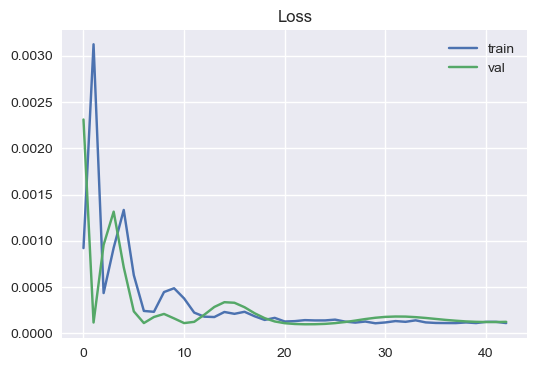

In [9]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss')
plt.show()

In [10]:
print("\nEvaluating on the final test set:")
y_pred_final = model.predict(X_test_final_seq).flatten()

final_rmse = np.sqrt(mean_squared_error(y_test_final_seq, y_pred_final))
print(f"Final Test RMSE: {final_rmse:.6f}")

final_direction_acc = np.mean(np.sign(y_pred_final) == np.sign(y_test_final_seq)) * 100
print(f"Final Test Sign Prediction Accuracy: {final_direction_acc:.2f}%")


Evaluating on the final test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Final Test RMSE: 0.006398
Final Test Sign Prediction Accuracy: 55.17%


## 6. Prediction & Evaluation

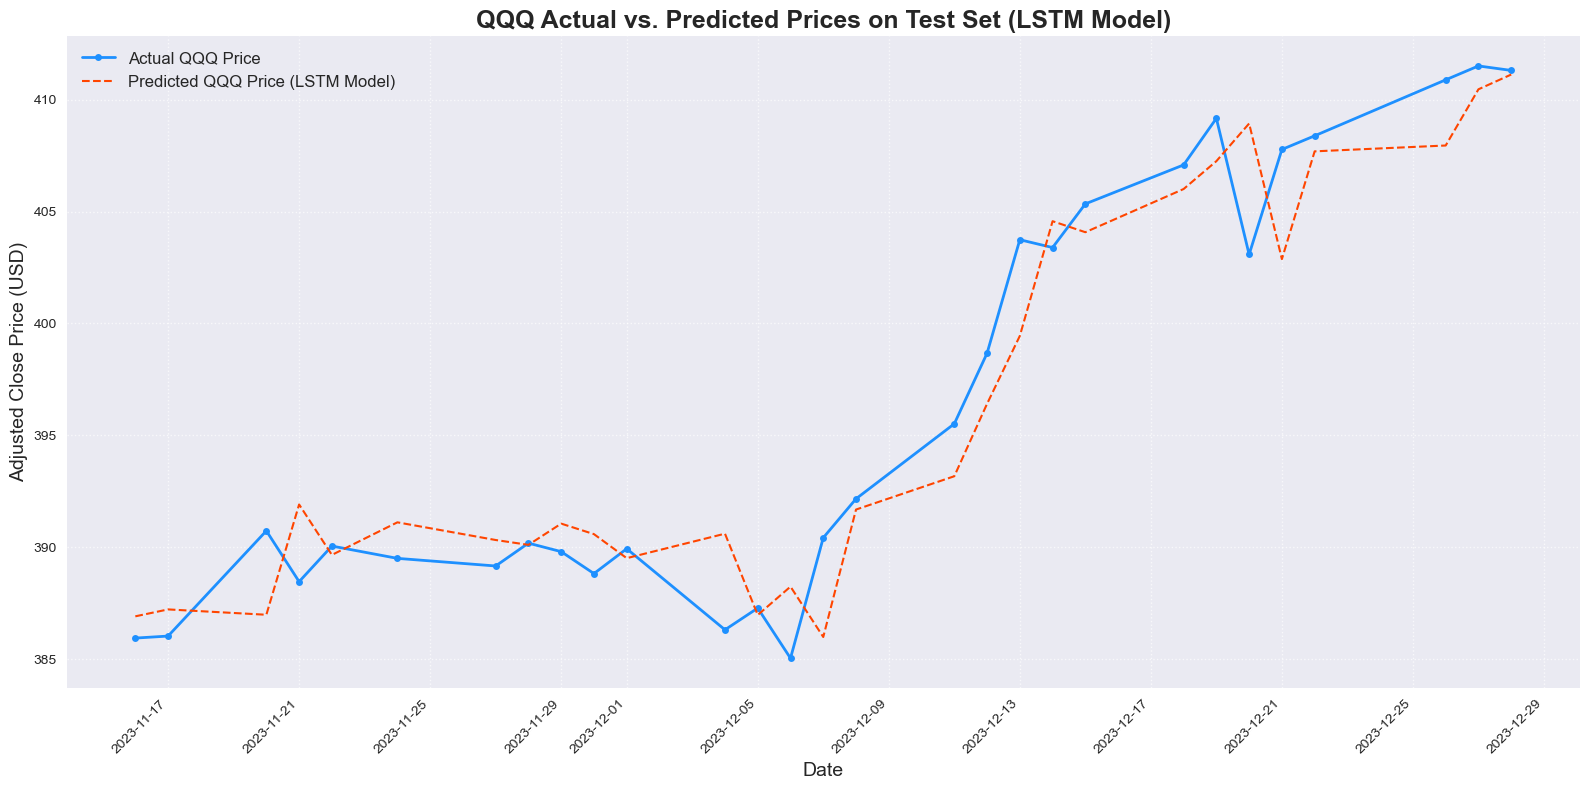

In [11]:
num_predictions = len(y_pred_final)


plot_start_index_in_test_df = final_seq_len 
plot_end_index_in_test_df = final_seq_len + num_predictions


plot_dates = test_df_final['date'].iloc[plot_start_index_in_test_df : plot_end_index_in_test_df]

actual_prices_to_plot = test_df_final['adj_close'].iloc[plot_start_index_in_test_df : plot_end_index_in_test_df].values

previous_day_actual_prices = test_df_final['adj_close'].iloc[plot_start_index_in_test_df - 1 : plot_end_index_in_test_df - 1].values

predicted_prices_to_plot = previous_day_actual_prices * (1 + y_pred_final)


plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(16, 8))

# Plot actual prices
plt.plot(plot_dates, actual_prices_to_plot, 
         label='Actual QQQ Price', 
         color='dodgerblue', 
         marker='o', 
         markersize=5, 
         linewidth=2,
         linestyle='-')

# Plot predicted prices
plt.plot(plot_dates, predicted_prices_to_plot, 
         label='Predicted QQQ Price (LSTM Model)', 
         color='orangered', 
         marker='x', 
         markersize=6, 
         linewidth=1.5,
         linestyle='--')

# Title and Labels
plt.title('QQQ Actual vs. Predicted Prices on Test Set (LSTM Model)', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price (USD)', fontsize=14)

# Legend
plt.legend(fontsize=12, loc='upper left')

# Grid
plt.grid(True, linestyle=':', alpha=0.7) 

# Date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15)) 
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)


plt.tight_layout()
plt.show()